# Template for Processing of bulk counts table

This notebook provides a structured workflow for processing dual RNA-seq count data of bacterial phage infections. It begins by loading the necessary input files including raw count tables, SRA metadata, and genome annotations. Using a custom `tools.py` module, the notebook performs:

- Dataset formatting 
- Gene Annotation (based on gff3 file)
- In silico rRNA-depletion
- (Log)TPM-normalization
- PCA Analysis (outlier detection)
- Data summarization (mean, sd, ...)
- Phage gene classification (early, middle, late genes)

The dual RNA-seq dataset from Wolfram-Schauerte et al. (2022) [1], which captures E. coli infection by T4 phage, is analyzed as an illustrative example, serving as a generalizable template for similar analyses.

[1] Wolfram-Schauerte M, Pozhydaieva N, Viering M, Glatter T, Höfer K. Integrated Omics Reveal Time-Resolved Insights into T4 Phage Infection of E. coli on Proteome and Transcriptome Levels. Viruses. 2022 Nov 12;14(11):2502. doi: 10.3390/v14112502. PMID: 36423111; PMCID: PMC9697503.

Import all required packages. The python script `tools.py` contains all self-written functions required for data processing.

In [72]:
# Use conda environment with required packages installed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *

## 1 Load the dataset and annotation

We start by loading the raw counts table, metadata and concatenated gff3 file including host and phage.

In [ ]:
# Raw counts table, output from nextflow pipeline
bulkPath = '/output/countData/countData.tsv' 
# Metadata from SRA. Can be aquired from SRA Run Selector
metaPath = '/input/SraRunTable.csv'
# Concatenated phage/host gff3 file, output from nextflow pipeline
gffPath = '/output/alignments/dualGenome.gff3'


# Load data as pandas dataframe
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

In [74]:
df_initial.head(2)

,Chr,Start,End,Strand,Length,SRR21013141_sorted.bam,SRR21013146_sorted.bam,SRR21013150_sorted.bam,SRR21013144_sorted.bam,SRR21013140_sorted.bam,SRR21013139_sorted.bam,SRR21013138_sorted.bam,SRR21013145_sorted.bam,SRR21013142_sorted.bam,SRR21013136_sorted.bam,SRR21013149_sorted.bam,SRR21013137_sorted.bam,SRR21013143_sorted.bam,SRR21013147_sorted.bam,SRR21013148_sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,
gene-b0001,U00096.3,190,255,+,66,77,1160,3027,242,421,195,144,3103,772,32,2203,202,815,5352,1081
gene-b0002,U00096.3,337,2799,+,2463,401,2725,9156,2943,849,769,321,3004,1751,204,6646,351,1141,5380,3658


In [75]:
metadata.head(2)

,Run,Assay Type,AvgSpotLen,bacteriophage,Bases,BioProject,BioSample,Bytes,Center Name,Consent,...,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment
0,SRR21013136,RNA-Seq,85,"Escherichia phage T4 (DSMZ, Braunschweig, Germ...",1804280125,PRJNA868713,SAMN30261892,753692490,MAX-PLANCK-INSTITUTE FOR TERRESTRIAL MICROBIOLOGY,public,...,ILLUMINA,2022-11-09T00:00:00Z,2022-08-11T11:52:00Z,1,GSM6447628,Escherichia coli (Migula 1895) Castellani and ...,SRP391066,Escherichia coli (Migula 1895) Castellani and ...,20 min,infected with T4 phage
1,SRR21013137,RNA-Seq,85,"Escherichia phage T4 (DSMZ, Braunschweig, Germ...",3703168565,PRJNA868713,SAMN30261893,1540473729,MAX-PLANCK-INSTITUTE FOR TERRESTRIAL MICROBIOLOGY,public,...,ILLUMINA,2022-11-09T00:00:00Z,2022-08-11T11:55:00Z,1,GSM6447627,Escherichia coli (Migula 1895) Castellani and ...,SRP391066,Escherichia coli (Migula 1895) Castellani and ...,20 min,infected with T4 phage


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annoate samples names. We do this manually by adding another sample name column to the metadata with proper sample annotation (timepoint + replicate) based on GEO Sample accessions (GSExyz) using `sampleDict`.

`annotateData(metadata, sampleDict)` adds the new sample name column and indexes the dataframe with SRA Run accession number matching the counts table column names (SRRxyz_sorted.bam) to prepare updating counts table column names.

In [76]:
# Match GSM IDs and SampleNames inferred from GEO
sampleDict = {'GSM6447614': '0_R1', 'GSM6447615': '0_R2', 'GSM6447616': '0_R3', 'GSM6447617': '1_R1', 'GSM6447618': '1_R2', 'GSM6447619': '1_R3',
              'GSM6447620': '4_R1', 'GSM6447621': '4_R2', 'GSM6447622': '4_R3', 'GSM6447623': '7_R1', 'GSM6447624': '7_R2', 'GSM6447625': '7_R3',
              'GSM6447626': '20_R1', 'GSM6447627': '20_R2', 'GSM6447628': '20_R3'}

In [77]:
# Update metadata dataframe
metadataFull = annotateData(metadata, sampleDict)

In [78]:
# Updated metadata
metadataFull.head(2)

,Run,Assay Type,AvgSpotLen,bacteriophage,Bases,BioProject,BioSample,Bytes,Center Name,Consent,...,create_date,version,Sample Name,source_name,SRA Study,strain,time,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,
SRR21013136_sorted.bam,SRR21013136,RNA-Seq,85,"Escherichia phage T4 (DSMZ, Braunschweig, Germ...",1804280125,PRJNA868713,SAMN30261892,753692490,MAX-PLANCK-INSTITUTE FOR TERRESTRIAL MICROBIOLOGY,public,...,2022-08-11T11:52:00Z,1,GSM6447628,Escherichia coli (Migula 1895) Castellani and ...,SRP391066,Escherichia coli (Migula 1895) Castellani and ...,20 min,infected with T4 phage,SRR21013136_sorted.bam,20_R3
SRR21013137_sorted.bam,SRR21013137,RNA-Seq,85,"Escherichia phage T4 (DSMZ, Braunschweig, Germ...",3703168565,PRJNA868713,SAMN30261893,1540473729,MAX-PLANCK-INSTITUTE FOR TERRESTRIAL MICROBIOLOGY,public,...,2022-08-11T11:55:00Z,1,GSM6447627,Escherichia coli (Migula 1895) Castellani and ...,SRP391066,Escherichia coli (Migula 1895) Castellani and ...,20 min,infected with T4 phage,SRR21013137_sorted.bam,20_R2


Based on the updated metadata, we can now rename the columns of our counts table by running `changeColnames`. Input is:

1. Raw counts table without gene Chr, Start, End, Strand, Length information `df_initial.iloc[:,5:df_initial.shape[1]]`
2. and updated metadata `metadataFull`

Finally, we can sort the columns properly.

In [79]:
# Update column names of raw counts table.
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)

# Sort columns properly
df = df[['0_R1', '0_R2', '0_R3', '1_R1', '1_R2', '1_R3', '4_R1', '4_R2', '4_R3', '7_R1', '7_R2', '7_R3', '20_R1', '20_R2', '20_R3']]
df.head(2)

SampleNames,0_R1,0_R2,0_R3,1_R1,1_R2,1_R3,4_R1,4_R2,4_R3,7_R1,7_R2,7_R3,20_R1,20_R2,20_R3
Geneid,,,,,,,,,,,,,,,
gene-b0001,3027,2203,1081,5352,1160,3103,242,815,772,77,421,195,144,202,32
gene-b0002,9156,6646,3658,5380,2725,3004,2943,1141,1751,401,849,769,321,351,204


### 2.2 Remove rRNA genes

To perform depletion of ribosomal RNA genes, which quantitatively make up the majority of RNA within a sample, we consult the gff3 file with host and phage information to get rRNA GeneIDs. We do this by filtering the gff3 file for gene entries and accessing the attributes column to get GeneIDs, GeneType and GeneSymbol (important for later processing). Example:

- GeneID: gene-b0001
- GeneType: protein_coding
- GeneSymbol: thrL (Important note: gene symbols not available for most genes.)

Based on GeneType {'protein_coding', rRNA', 'tRNA', etc}, we can extract all annotated rRNA genes that are then depleted by applying `rRNAdepletion(df,rRNAs)`.

In [ ]:
# Load ggf3 file and filter for gene entries
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format new columns GeneID, GeneType and GeneSymbol by extracting substrings of attributes column
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage column based on seqid column
entity = {'U00096.3' : 'host', 'NC_000866.4' : 'phage'} # this needs to be adapted depending on phage-host interaction
gff3['Entity'] = gff3[0].map(entity)

# Index dataframe with GeneID (important for rRNAdepeltion)
gff3.index = gff3['ID']

# Extract list with rRNA entries based on GeneType column
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

# Perform rRNA depletion
df_norRNAs = rRNAdepletion(df,rRNAs)

# Verify rRNA depletion
print(f"Genes before rRNA depletion: {df.shape[0]}")
print(f"Genes after  rRNA depletion: {df_norRNAs.shape[0]}")

Genes before rRNA depletion: 4794
Genes after  rRNA depletion: 4772


In [81]:
gff3.head(2)

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-b0001,U00096.3,Genbank,gene,190.0,255.0,.,+,.,"ID=gene-b0001;Dbxref=ASAP:ABE-0000006,ECOCYC:E...",gene-b0001,protein_coding,thrL,host
gene-b0002,U00096.3,Genbank,gene,337.0,2799.0,.,+,.,"ID=gene-b0002;Dbxref=ASAP:ABE-0000008,ECOCYC:E...",gene-b0002,protein_coding,thrA,host


### 2.3 TPM normalization

Now we can tpm normalize the raw counts table using `TPM(df_norRNAs, df_initial, 0.5)` specifying a pseudocount of `0.5`. We further add `Entity` (Host or Phage) and `Symbol` (GeneSymbol) to the `tpms` and `df_norRNAs` dataframe.

In [82]:
# TPM normalization of raw counts
tpms = TPM(df_norRNAs, df_initial, 0.5)

# Add Entity and Symbol columns to df_norRNAs
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity'].astype(str)
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol'].astype(str)
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

Next, we use `fillSymbols(tpms)` to assign gene IDs to entries where gene symbols are missing (i.e., `Symbol = None`). Then, `make_unique_with_index(tpms)` is applied to ensure GeneSymbols are unique. If not, corresponding GeneIDs are concatenated with GeneSymbols.

In [83]:
# GeneSymbols are added to tpm table
tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms.head(2)

SampleNames,0_R1,0_R2,0_R3,1_R1,1_R2,1_R3,4_R1,4_R2,4_R3,7_R1,7_R2,7_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-b0850,180.730906,185.729172,170.394260,156.911836,147.125838,127.670627,39.943664,27.331049,29.970388,11.659338,13.015975,13.265718,6.004038,7.127155,6.080128,host,ybjC
gene-b1134,25.592033,30.496105,30.525236,26.081914,28.428376,25.043394,19.549913,7.810385,7.004481,3.136389,3.076537,2.793575,1.148773,2.286614,1.048356,host,nudJ


### 2.4 logTPM normalization

TPM values are further log-transformed using `logNorm(tpms.iloc[:, :-2])` (raw TPM matrix as input). Entity and Symbols are added afterwards.

In [84]:
# Log transformation of tpm values
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs.head(2)

SampleNames,0_R1,0_R2,0_R3,1_R1,1_R2,1_R3,4_R1,4_R2,4_R3,7_R1,7_R2,7_R3,20_R1,20_R2,20_R3,Entity,Symbol
Geneid,,,,,,,,,,,,,,,,,
gene-b0850,7.505660,7.544804,7.421175,7.302975,7.210680,7.007539,5.355568,4.824312,4.952818,3.662130,3.809000,3.834480,2.808187,3.022750,2.823775,host,ybjC
gene-b1134,4.732922,4.977102,4.978435,4.759258,4.879136,4.702846,4.361060,3.139205,3.000808,2.048372,2.027344,1.923558,1.103513,1.716602,1.034466,host,nudJ


## 3 Filter samples, if necessary

After tpm normalization, we now evaluate data quality by performing PCA anaylsis on our replicates (tpms and logTPMs) using the `txPCA()` function, which again takes the raw Data matrix without `Entity` and `Symbol` as input. Potential outliers can be identified here and filtered out for further data analysis.

In [ ]:
# This needs to be adapted depending on the dataset
columnOrder = ['0_R1', '0_R2', '0_R3', 
               '1_R1', '1_R2', '1_R3', 
               '4_R1', '4_R2', '4_R3', 
               '7_R1', '7_R2', '7_R3', 
               '20_R1', '20_R2', '20_R3']

Text(0.5, 1.0, 'PCA on TPM values')

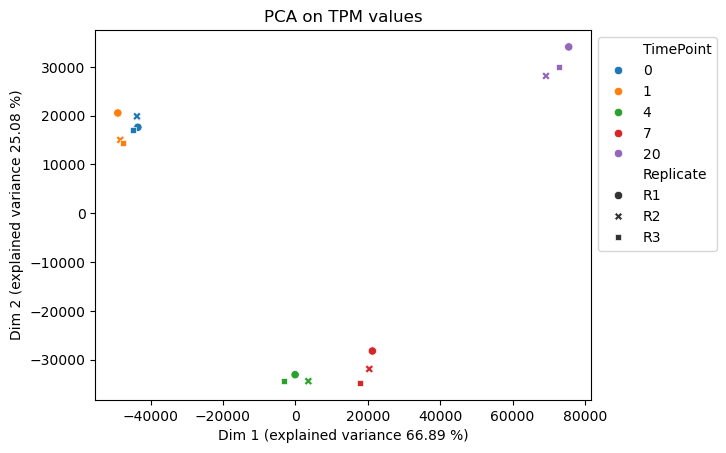

In [86]:
# PCA on tpms values
txPCA(tpms[columnOrder])
plt.title("PCA on TPM values")

Text(0.5, 1.0, 'PCA on logTPM values')

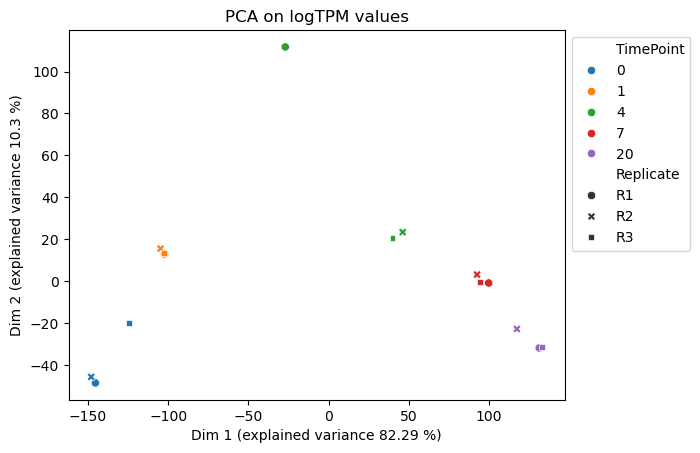

In [87]:
# PCA on logTPM values
txPCA(logTPMs[columnOrder])
plt.title("PCA on logTPM values")

For further analysis, PCA is performed on host and phage genes separately. For this, we filter our dataframes for the corresponding genes.

In [88]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

Text(0.5, 1.0, 'PCA on TPM_Host values')

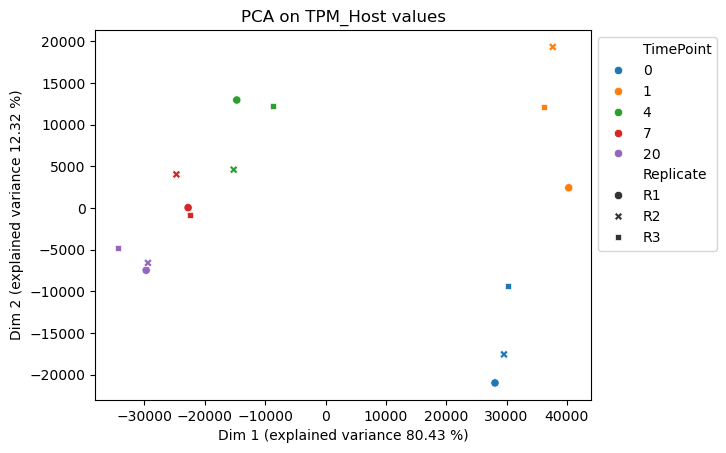

In [89]:
# tpmHost
txPCA(tpmHost[columnOrder])
plt.title("PCA on TPM_Host values")

tpmPhage

Text(0.5, 1.0, 'PCA on TPM_Phage values')

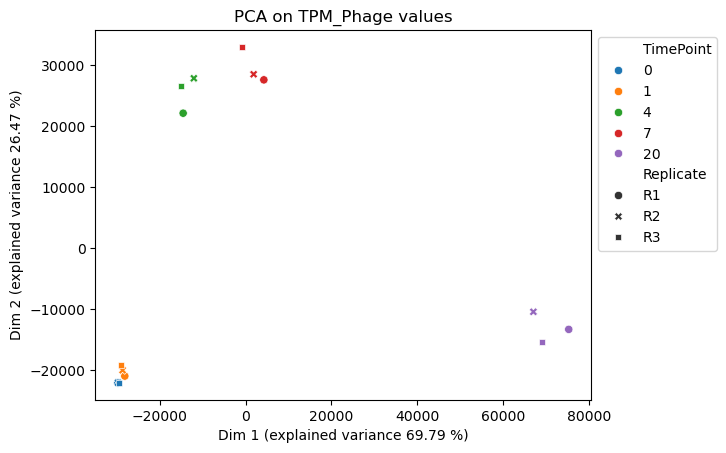

In [90]:
# tpmPhage
txPCA(tpmPhage[columnOrder])
plt.title("PCA on TPM_Phage values")

logTPM Host

Text(0.5, 1.0, 'PCA on logTPM_Host values')

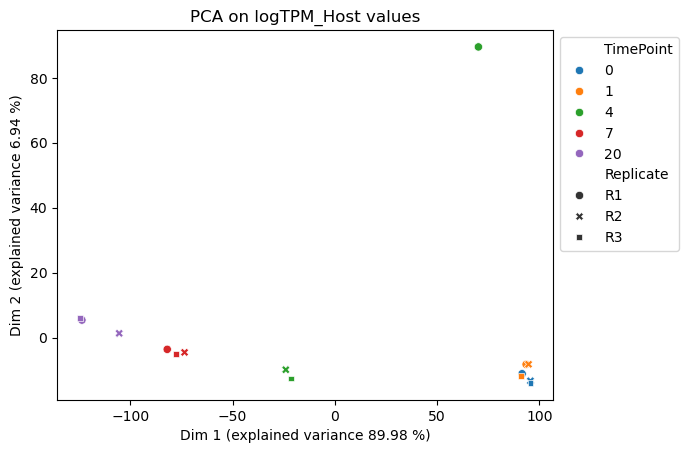

In [91]:
# logTPM Host
txPCA(logTPMsHost[columnOrder])
plt.title("PCA on logTPM_Host values")

Text(0.5, 1.0, 'PCA on logTPM_Phage values')

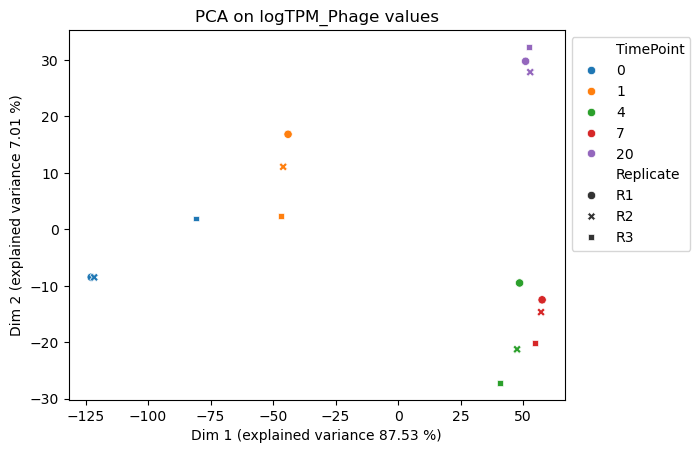

In [92]:
# logTPM Phage
txPCA(logTPMsPhage[columnOrder])
plt.title("PCA on logTPM_Phage values")

We identify Sample 4_R1 as potential outlier in the PCA on logTPM and logTPM_Host values. Therefore, we have to decide whether we want to remove this datapoint from further analysis. To test this, we perform PCA anaylsis on samples without this datapoint.

In [93]:
# Update all tables by excluding 4_R1
updatedOrder = ['0_R1', '0_R2', '0_R3', '1_R1', '1_R2', '1_R3', '4_R2', '4_R3', '7_R1', '7_R2', '7_R3', '20_R1', '20_R2', '20_R3']

Text(0.5, 1.0, 'PCA on TPM values after excluding sample 4_R1')

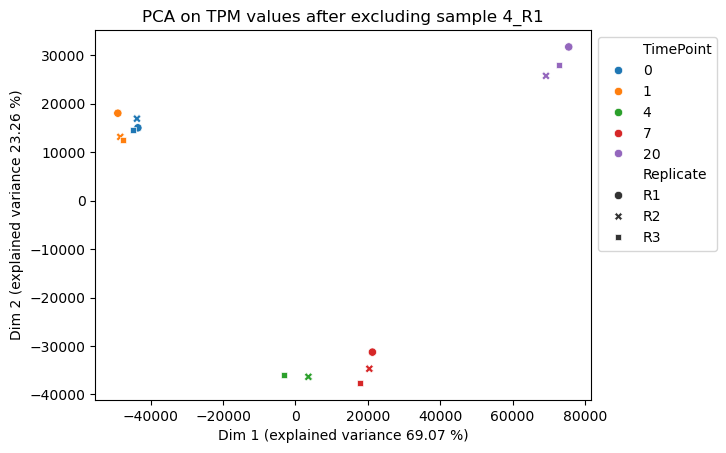

In [94]:
# Updated tpms
txPCA(tpms[updatedOrder])
plt.title("PCA on TPM values after excluding sample 4_R1")

Text(0.5, 1.0, 'PCA on logTPM values after excluding sample 4_R1')

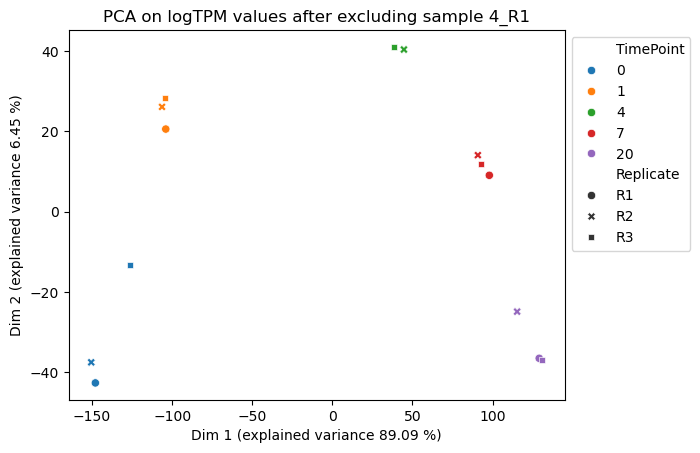

In [95]:
# Updated logTPMs
txPCA(logTPMs[updatedOrder])
plt.title("PCA on logTPM values after excluding sample 4_R1")

Text(0.5, 1.0, 'PCA on TPM_Host values after excluding sample 4_R1')

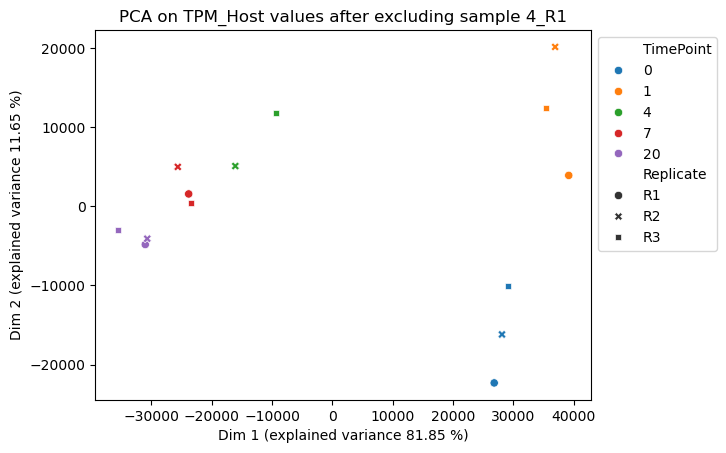

In [96]:
# Updated tpmHost
txPCA(tpmHost[updatedOrder])
plt.title("PCA on TPM_Host values after excluding sample 4_R1")

Text(0.5, 1.0, 'PCA on TPM_Phage values after excluding sample 4_R1')

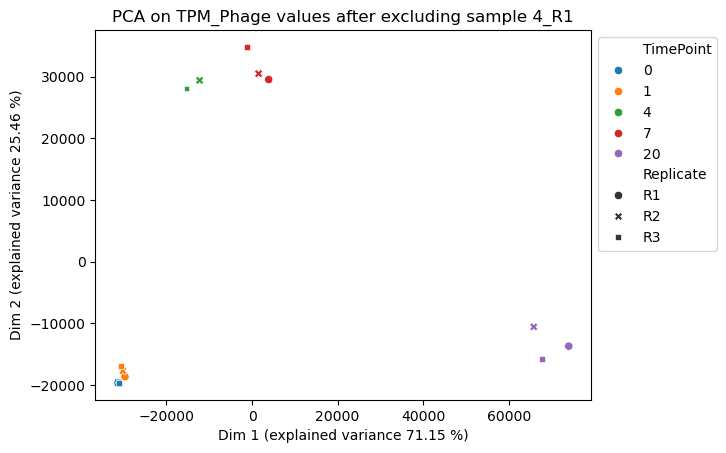

In [97]:
# tpmPhage
txPCA(tpmPhage[updatedOrder])
plt.title("PCA on TPM_Phage values after excluding sample 4_R1")

Text(0.5, 1.0, 'PCA on logTPM_Host values after excluding sample 4_R1')

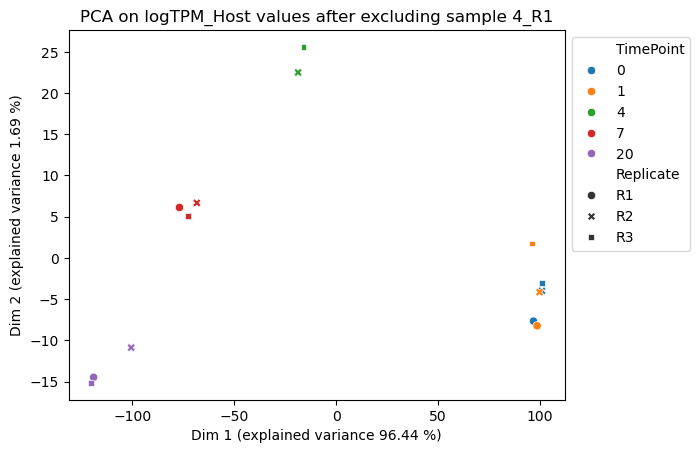

In [98]:
# logTPM Host
txPCA(logTPMsHost[updatedOrder])
plt.title("PCA on logTPM_Host values after excluding sample 4_R1")

Text(0.5, 1.0, 'PCA on logTPM Phage values after excluding sample 4_R1')

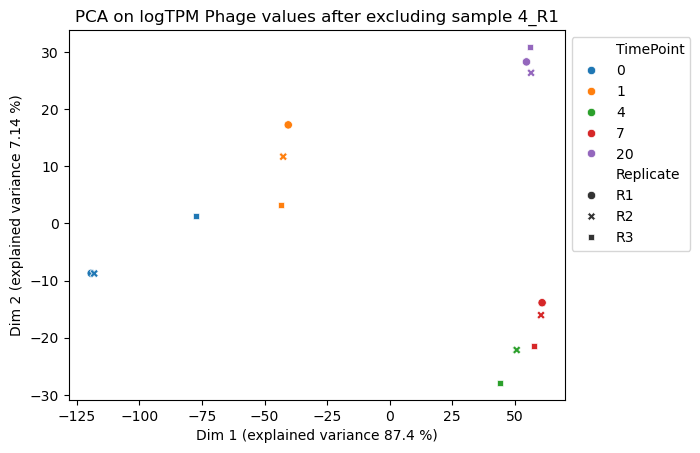

In [99]:
# logTPM Phage
txPCA(logTPMsPhage[updatedOrder])
plt.title("PCA on logTPM Phage values after excluding sample 4_R1")

After PCA analysis on data with excluded 4_R1, we decided to remove this datapoint from further analysis.

## 4. Final grouping

We will now summarize time points with mean and standard deviation for TPM-normalized data. First, we update the tpms and raw counts dataframe by dropping sample 4_R1, as well as adding the Entity and Symbol column to df_norRNAs.

In [100]:
# Updated tpms dataframe 
tpmsUpdated = tpms.drop('4_R1', axis = 1)

# Updated raw counts dataframe
df_norRNAsUpdated = df_norRNAs.drop('4_R1', axis = 1)

Next, we generate dataframes containing mean and standard deviation of gene expression values at specific timepoints by applying `getMeanSD` which again takes raw tpms matrix (without `Entity` and `Symbol`) as input. After creation, we add `Entity` and `Symbol` again.

In [101]:
# Create dataframes for tpm means and standard deviations
TPMmeans, TPMsds = getMeanSD(tpmsUpdated[updatedOrder])

In [ ]:
# Add Entity and Symbol to TPMmeans again
TPMmeans = TPMmeans[['0', '1', '4', '7', '20']] # adapt to dataset
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans.head(2)

,0,1,4,7,20,Entity,Symbol
Geneid,,,,,,,
gene-b0850,178.951446,143.902767,28.650718,12.647011,6.403774,host,ybjC
gene-b1134,28.871125,26.517894,7.407433,3.002167,1.494581,host,nudJ


In [ ]:
# Add Entity and Symbol to TPMsds again
TPMsds = TPMsds[['0', '1', '4', '7', '20']] # adapt to dataset
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds.head(2)

,0,1,4,7,20,Entity,Symbol
Geneid,,,,,,,
gene-b0850,7.820789,14.884664,1.866295,0.864416,0.627621,host,ybjC
gene-b1134,2.839814,1.734095,0.569860,0.183108,0.687756,host,nudJ


We also calculate relative expression values for each gene, using TPM-normalized means to scale to highest expression per gene across time points, by running `proportionalExp` on the raw TPMmeans matrix. Afterwards, we again add `Entity` and `Symbol` to the dataframe.

In [ ]:
# Create dataframe with relative expression values compared to highest expression timepoint
TPMmeansCopy = TPMmeans[['0','1','4','7','20']].copy() # adapt to dataset
propExp = proportionalExp(TPMmeansCopy)
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp.head(2)

,0,1,4,7,20,Entity,Symbol
Geneid,,,,,,,
gene-b0850,1.0,0.804144,0.160103,0.070673,0.035785,host,ybjC
gene-b1134,1.0,0.918492,0.256569,0.103985,0.051767,host,nudJ


## 5. Phage gene classification

Next, we classify phage genes into early, middle, or late categories based on their temporal expression profiles throughout the infection. For this, we use two functions — `classLabelThreshold()` and `classLabelMax()` — which assign genes to classes based on:

- whether their expression at a given timepoint exceeds 20% of their maximum expression (classLabelThreshold), or
- the timepoint at which maximum expression occurs (classLabelMax).

Timepoint boundaries for classification can chosen based on the given data as well as already known criteria. They are hardcoded into the classification functions:

- Early genes: Meet the classification criteria at timepoints 1 or 4
- Middle genes: Meet the classification criteria at timepoint 7
- Late genes: Meet the classification criteria at timepoint 20

One may need to add more conditions, if more timepoints are available.

In [105]:
# Add a classification label based on exceeding 20 % of maximal expression
def classLabelThreshold(tpm):
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:
        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])
        # Get maximal value for each gene across time points
        maxTPM = max(expressions)
        # Get the threshold value
        thresHold = maxTPM*0.2
        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]
        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [106]:
# Add a classification label based on maximal expression 
def classLabelMax(tpm):
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:
        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])
        # Get maximal value for each gene across time points
        maxTPM = max(expressions)
        # Get the threshold value
        thresHold = maxTPM
        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]
        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('None')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [107]:
# Classify phage genes according to set timepoints in the respective functions
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [108]:
TPMmeans[TPMmeans["Entity"] == "phage"].head(2)

,0,1,4,7,20,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,
gene-T4p061,4.814848,16.005894,2051.378806,4933.134534,7795.153831,phage,a-gt.2,early,late
gene-T4p043,1.023376,3.289629,1860.636332,2774.388611,907.192680,phage,b-gt,early,middle


We also add determined classes to other dfs.

In [109]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpmsUpdated[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

## 6. Add variance to all dataframes

Lastly, we will assess the variability of each gene based on its gene expressionl. To do so, we calculate the stabilized variance of tpm expression values (variance / mean) for each gene across all timepoints and replicates using the function `stabilizedVariance`.

In [110]:
# Add stabilized variance of genes over timepoints to tpms dataframe
tpmsUpdated = stabilizedVariance(tpmsUpdated)
tpmsUpdated.head()

SampleNames,0_R1,0_R2,0_R3,1_R1,1_R2,1_R3,4_R2,4_R3,7_R1,7_R2,7_R3,20_R1,20_R2,20_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,,,
gene-b0850,180.730906,185.729172,170.394260,156.911836,147.125838,127.670627,27.331049,29.970388,11.659338,13.015975,13.265718,6.004038,7.127155,6.080128,host,ybjC,None,None,71.310410
gene-b1134,25.592033,30.496105,30.525236,26.081914,28.428376,25.043394,7.810385,7.004481,3.136389,3.076537,2.793575,1.148773,2.286614,1.048356,host,nudJ,None,None,10.674000
gene-b4024,98.362115,96.628978,93.605821,106.172278,116.090988,87.683998,9.162409,9.558014,5.135331,6.336810,6.007252,3.208494,4.910072,3.008154,host,lysC,None,None,47.590769
gene-b0195,74.943624,80.264247,80.221468,75.513403,89.876589,91.207677,15.874548,19.134211,6.335964,7.168367,6.738478,3.570785,5.094829,3.560810,host,trmO,None,None,34.028867
gene-b1960,0.015095,0.013678,0.032795,0.031365,0.045049,0.020053,0.011878,0.012424,0.018422,0.008047,0.013633,0.012116,0.011621,0.026367,host,vsr,None,None,0.005366


Calculated variances are further added to other dataframes.

In [111]:
# Add variance to other dataframes
TPMmeans['Variance'] = tpmsUpdated['Variance']
TPMsds['Variance'] = tpmsUpdated['Variance']
propExp['Variance'] = tpmsUpdated['Variance']

## 7. Write data to output

In [ ]:
# Full TPM table
tpmsUpdated.to_csv('Wolfram-Schauerte_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAsUpdated.to_csv('Wolfram-Schauerte_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Wolfram-Schauerte_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Wolfram-Schauerte_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Wolfram-Schauerte_fractional_expression.tsv', sep = '\t')